### Imports & Settings

In [183]:
import torch

from torch import nn, optim

from torch.utils.data import DataLoader, TensorDataset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

import cv2

import copy
import time

In [184]:
torch.manual_seed(123)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.__version__)
print(device)

2.2.0+cu121
cuda


### Modules

In [185]:
class SineActivation(nn.Module):
    def __init__(self):
        super(SineActivation, self).__init__()
        
    def forward(self, x):
        return torch.sin(x)

In [186]:
class FullyConnected(nn.Module):
    '''
    Builds a fully connected neural network from a list of layer sizes and an optional activation function.
    
    Args:
        fc_sizes (list): Sizes of each layer in the network.
        activation (nn.Module): Activation function applied between layers, defaults to SineActivation.
    '''
    def __init__(self, fc_sizes: list, activation=SineActivation):
        super(FullyConnected, self).__init__()
        
        layers = []
        for size_in, size_out in zip(fc_sizes[:-1], fc_sizes[1:-1]):
            layers.append(nn.Linear(size_in, size_out))
            layers.append(activation())
        
        layers.append(nn.Linear(fc_sizes[-2], fc_sizes[-1]))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

### Utils

In [187]:
def timer(func):
    '''
    Decorator to measure and print the execution time of the decorated function.

    Args:
        func (callable): Function to measure.

    Returns:
        callable: Wrapped function with timing.
    '''
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f'Executed in {end_time - start_time} seconds.')
        return result
    return wrapper

In [188]:
def get_normal_field(f):
    def normal_field(x):
        '''
        Compute the normal to the implicit surface represented by a predetermined neural signed distance field.

        Args:
            x (torch.Tensor): A tensor representing a vector in the input space where the normal will be computed.

        Returns:
            torch.Tensor: The normal to the zero-level set of the neural field at point `x`, normalized to unit length.
        '''
        x = x.requires_grad_(True) 

        f_value = f(x)
        grad = torch.autograd.grad(
            outputs=f_value, 
            inputs=x, 
            grad_outputs=torch.ones_like(f_value),
            create_graph=True)[0]
        normal = grad / torch.sqrt(torch.sum(grad ** 2))

        return normal
    return normal_field


In [189]:
def get_uniform_field(f):
    return uniform_field

def uniform_field(x):
    return torch.ones_like(x)

In [190]:
def get_mean_curvature_field(f):
    def mean_curvature_field(x):
        '''
        Compute the mean curvature normal for the implicit surface represented by a neural signed distance field.

        Args:
            x (torch.Tensor): A tensor representing a vector in the input space where the mean curvature normal will be computed.

        Returns:
            torch.Tensor: The mean curvature normal of the zero-level set of the neural field at point `x`.
        '''
        x = x.requires_grad_(True)

        f_value = f(x)
        grad = torch.autograd.grad(
            outputs=f_value,
            inputs=x,
            grad_outputs=torch.ones_like(f_value),
            create_graph=True)[0]

        grad_norm = grad / torch.sqrt(torch.sum(grad ** 2, dim=1, keepdim=True))

        hessian = []
        for i in range(grad.shape[1]):
            hess_grad = torch.autograd.grad(
                outputs=grad[:, i],
                inputs=x,
                grad_outputs=torch.ones_like(grad[:, i]),
                create_graph=True,
                retain_graph=True,
                only_inputs=True)[0]
            hessian.append(hess_grad)
        hessian = torch.stack(hessian, dim=2)

        mean_curvature_normal = torch.bmm(hessian, grad_norm.unsqueeze(2)).squeeze(2)

        return mean_curvature_normal
    return mean_curvature_field


In [191]:
def get_sphere_sdf(r):
    def sphere_sdf(x):
        '''
        Computes the signed distance from the point `x` to a sphere centered at the origin with radius `r`.

        Args:
            x (torch.Tensor): A tensor representing a point in space.

        Returns:
            float: The signed distance from the point `x` to the surface of the sphere.
        '''
        return torch.sum(x ** 2, dim=-1) - r ** 2
    return sphere_sdf

In [192]:
def get_star_sdf(r, n, m):
    def star_sdf(x):      
        an = torch.tensor(torch.pi / n, device=x.device)
        en = torch.tensor(torch.pi / m, device=x.device)
        
        acs = torch.tensor([torch.cos(an), torch.sin(an)], dtype=torch.float32, device=x.device)
        ecs = torch.tensor([torch.cos(en), torch.sin(en)], dtype=torch.float32, device=x.device)
        
        bn = torch.atan2(x[..., 1], x[..., 0]) % (2.0 * an) - an
        x = torch.norm(x, dim=-1, keepdim=True) * torch.cat((torch.cos(bn).unsqueeze(-1), torch.abs(torch.sin(bn)).unsqueeze(-1)), dim=-1)
        
        x = x - r * acs
        dot_product = torch.sum(x * ecs, dim=-1, keepdim=True)
        x = x + ecs * torch.clamp(-dot_product, 0.0, r * acs[1] / ecs[1])
        
        return torch.norm(x, dim=-1) * torch.sign(x[..., 0])
    return star_sdf

In [324]:
def get_heart_sdf():
    def heart_sdf(p):
       
        p[..., 0] = torch.abs(p[..., 0])

        # Define vectors
        vec1 = torch.tensor([0.25, 0.75], device=p.device)
        vec2 = torch.tensor([0.00, 1.00], device=p.device)

        cond = p[..., 1] + p[..., 0] > 1.0

        diff1 = p - vec1
        diff2 = p - vec2
        diff3 = p - 0.5 * torch.clamp_max(p[..., 0] + p[..., 1], 0.0).unsqueeze(-1)

        dot2 = lambda v: torch.sum(v ** 2, dim=-1)

        result1 = torch.sqrt(dot2(diff1)) - torch.sqrt(torch.tensor(2.0, device=p.device)) / 4.0
        result2 = torch.sqrt(torch.min(dot2(diff2), dot2(diff3))) * torch.sign(p[..., 0] - p[..., 1])

        return torch.where(cond, result1, result2)
    
    return heart_sdf

In [279]:
def make_annular(sdf_func, r):
    def onion_sdf(pos):
        sdf_values = sdf_func(pos)
        return torch.abs(sdf_values) - r
    return onion_sdf

In [193]:
def create_grid(res=100):
    '''
    Returns a grid of 2D points and the corresponding x, y meshgrid arrays.

    Args:
        res (int): The resolution of the grid, default is 100.

    Returns:
        grid (torch.Tensor): Flattened grid coordinates.
        x (torch.Tensor): X coordinates of the meshgrid.
        y (torch.Tensor): Y coordinates of the meshgrid.
    '''
    p = torch.linspace(-1, 1, res)
    x, y = torch.meshgrid(p, p, indexing='xy')
    grid = torch.stack((x.flatten(), y.flatten()), dim=-1).to(device)
    return grid, x, y

In [194]:
def plot_sdf(net, res=100, contour_lines=15, colormap='RdBu'):
    '''
    Visualizes the SDF generated by a neural network over a fixed range from -1 to 1 for both x and y axes.

    Args:
        net (torch.nn.Module): Neural network model to generate SDF values.
        res (int): Number of points along each axis (res x res grid).
        contour_lines (int): Number of contour lines in the plot.
        colormap (str): Colormap used for visualization.
    '''
    grid, x, y = create_grid(res)

    with torch.no_grad():
        z = net(grid).view(res, res).cpu()

    fig, ax = plt.subplots()

    max_abs_value = max(abs(z.min()), abs(z.max()))
    contour_levels = torch.linspace(-max_abs_value, max_abs_value, contour_lines)
    
    c = ax.contourf(
        x.numpy(), y.numpy(), z.numpy(), 
        levels=contour_levels.numpy(), 
        cmap=colormap, 
        origin='lower')
    plt.colorbar(c, ax=ax)
    
    ax.contour(x.numpy(), y.numpy(), z.numpy(), levels=[0], colors='black', linewidths=2)
    ax.set_aspect('equal', 'box')
    
    plt.show()

In [195]:
def generate_sdf_video(net, total_time_steps=100, res=200, fps=10):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    out = cv2.VideoWriter('sdf_evolution.mp4', fourcc, fps, (2*res, 2*res))

    grid, x, y = create_grid(res)

    dpi = 100  
    figsize = (2*res / dpi, 2*res / dpi)  

    for t in torch.linspace(0, 1, total_time_steps):
        with torch.no_grad():
            grid_t = torch.cat((grid.cpu(), t.repeat(grid.size(0), 1)), dim=1).to(device)
            z = net(grid_t).view(res, res).cpu()

        fig, ax = plt.subplots(figsize=figsize)
        max_abs_value = max(abs(z.min()), abs(z.max()))
        contour_levels = torch.linspace(-max_abs_value, max_abs_value, 15)

        ax.contourf(x.numpy(), y.numpy(), z.numpy(), levels=contour_levels.numpy(), cmap='RdBu')
        ax.contour(x.numpy(), y.numpy(), z.numpy(), levels=[0], colors='black', linewidths=2)
        ax.set_aspect('equal', 'box')
        ax.axis('off')  

        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        plt.close(fig)
        out.write(img)

### 1. Training a test SDF

In [196]:
layer_sizes = [2, 256, 256, 256, 256, 128, 128, 64, 64, 1]
net = FullyConnected(layer_sizes).to(device)

learning_rate = 1e-3
optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.001)

In [197]:
n = 50
grid, _, _ = create_grid(n)

In [308]:
# #sphere
#radius = .25
#sdf_values = get_sphere_sdf(radius)(grid)

# #star
#r = .75
#n = 5
#m = 3

#sdf_values = get_star_sdf(r, n, m)(grid.cpu())

he = 0.6
r = 0.05
sdf_values = make_annular(get_blobby_cross_sdf(he), r)(grid)


X = grid.to(device)
Y = sdf_values.to(device)
dataset = TensorDataset(X, Y)

batch_size = 1
dataloader = DataLoader(dataset, batch_size)

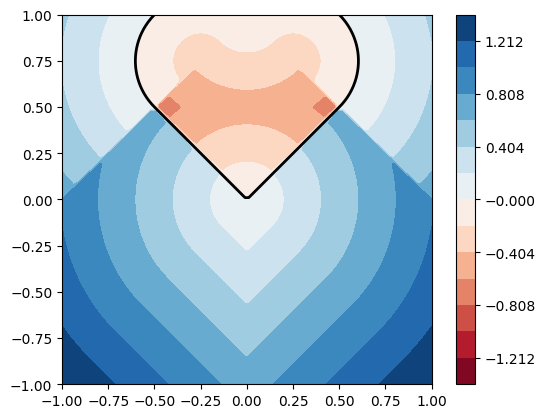

In [325]:
plot_sdf(get_heart_sdf())

In [200]:
num_epochs = 200
print_every = 5

In [201]:
def get_eikonal_loss(inputs, net):
    inputs.requires_grad_(True)
    outputs = net(inputs)
    grads = torch.autograd.grad(
        outputs=outputs,
        inputs=inputs,
        grad_outputs=torch.ones_like(outputs),
        create_graph=True,
        only_inputs=True)[0]
    gradient_norm = torch.norm(grads, dim=1)
    return ((gradient_norm - 1.0) ** 2).mean()

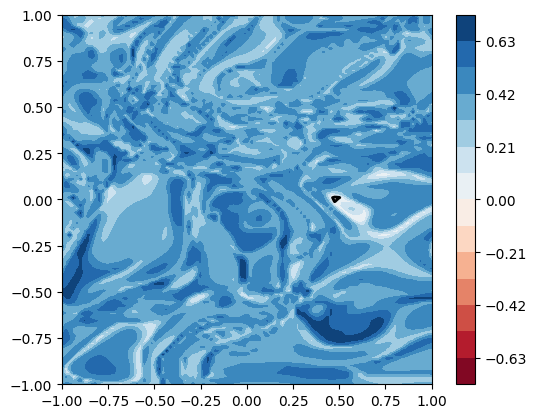

[5/200] Loss = 0.09551766514778137


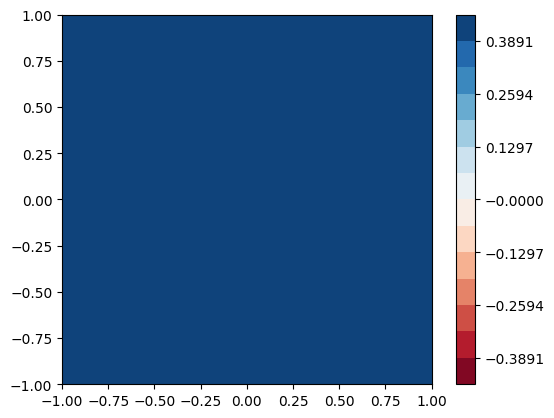

[10/200] Loss = 0.0948527604341507


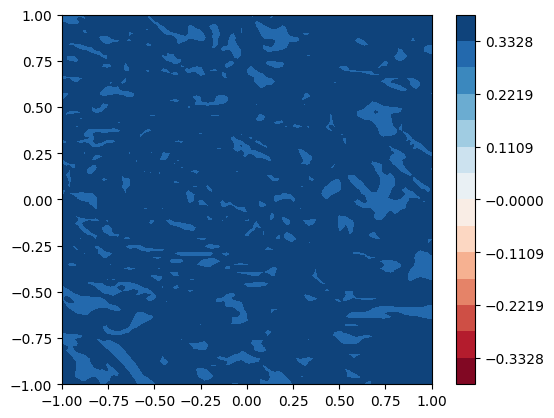

[15/200] Loss = 0.06842391192913055


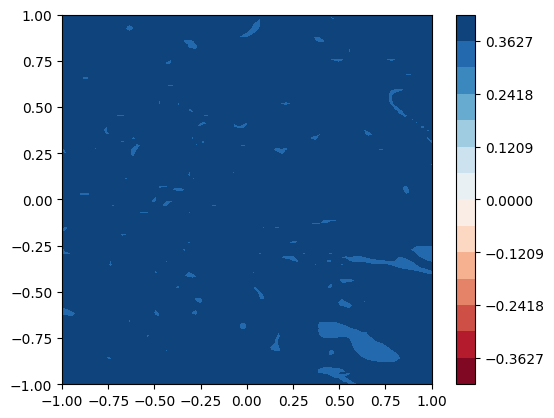

[20/200] Loss = 0.07870505750179291


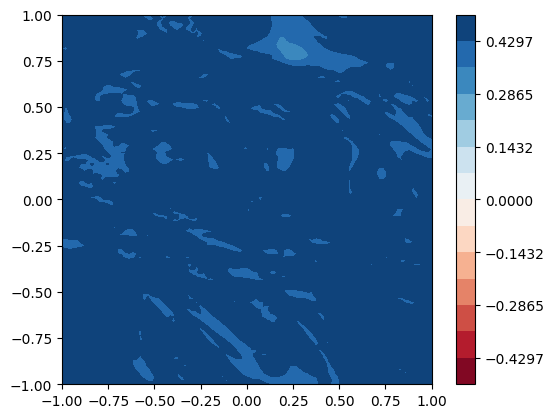

[25/200] Loss = 0.1033208817243576


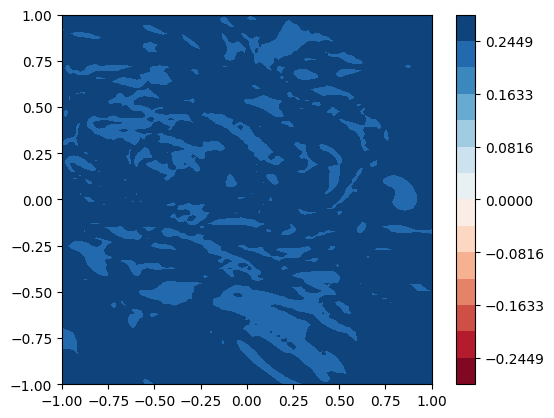

[30/200] Loss = 0.052186936140060425


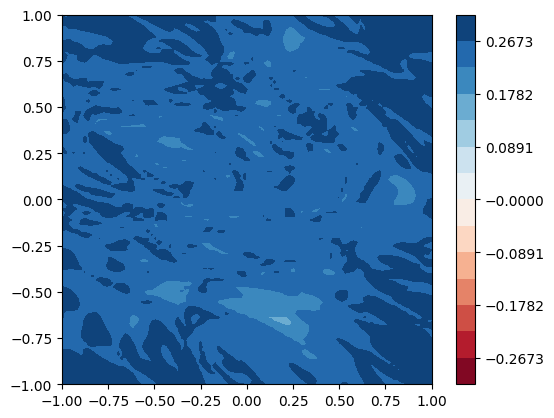

[35/200] Loss = 0.04916920140385628


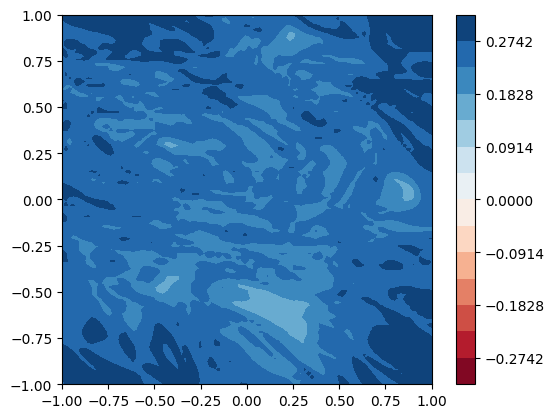

[40/200] Loss = 0.046004779636859894


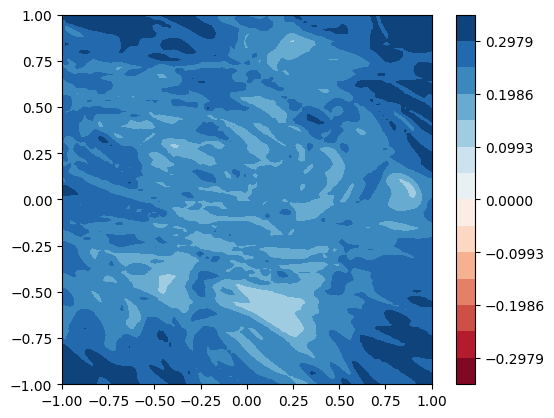

[45/200] Loss = 0.040354516357183456


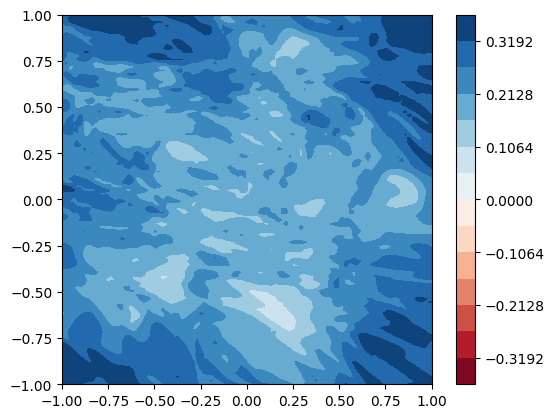

[50/200] Loss = 0.035191860049963


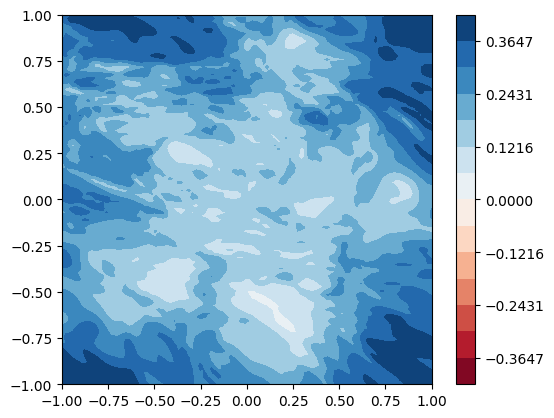

[55/200] Loss = 0.027109771966934204


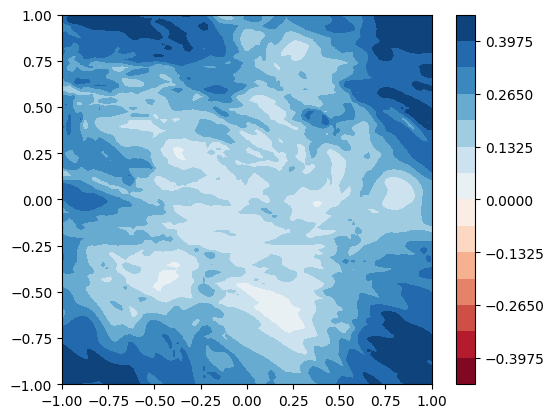

[60/200] Loss = 0.02226686291396618


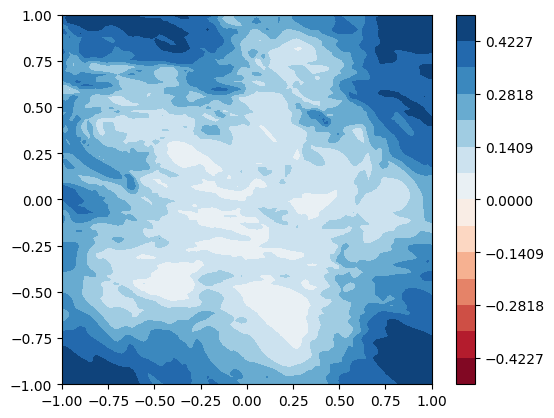

[65/200] Loss = 0.01682986691594124


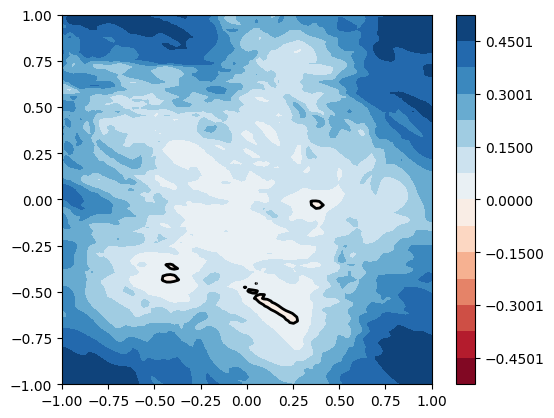

[70/200] Loss = 0.013627401553094387


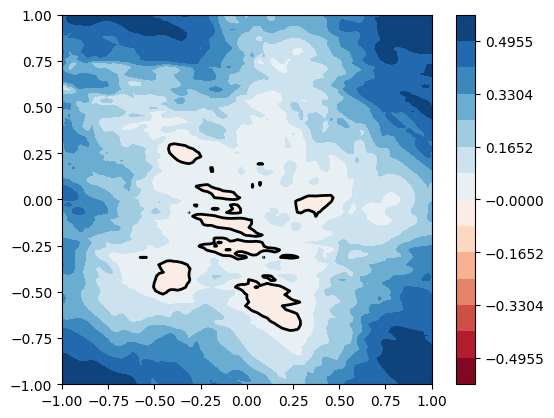

[75/200] Loss = 0.009448979049921036


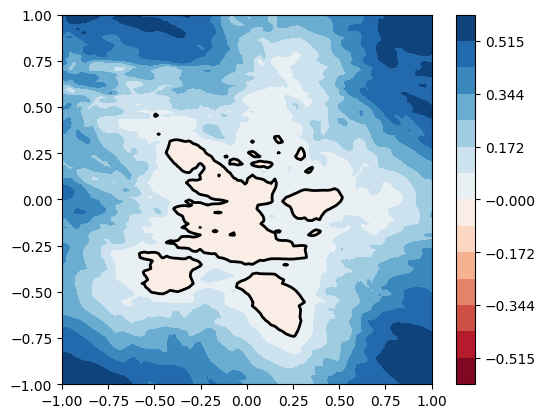

[80/200] Loss = 0.007010168861597776


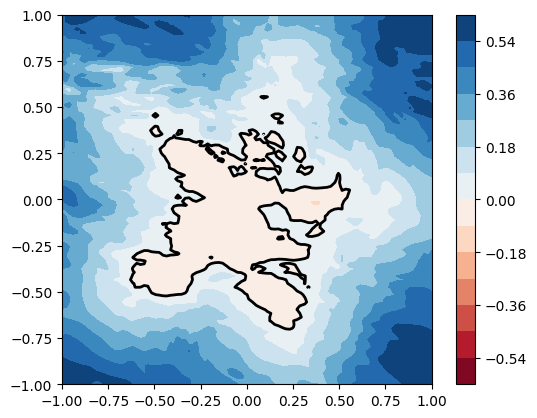

[85/200] Loss = 0.005224213469773531


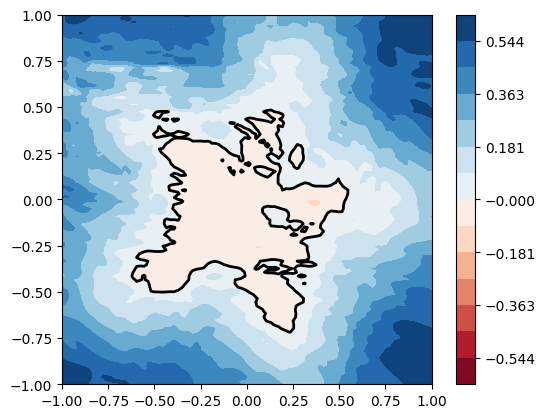

[90/200] Loss = 0.004595826845616102


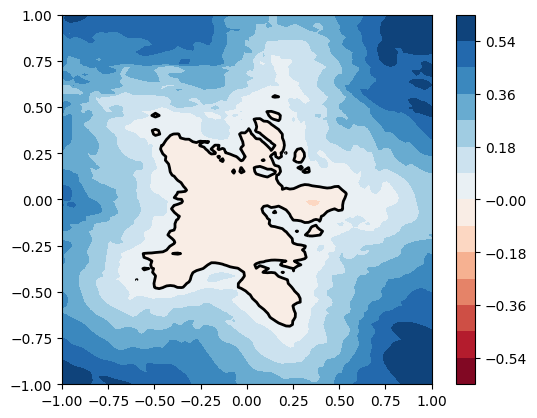

[95/200] Loss = 0.004350977949798107


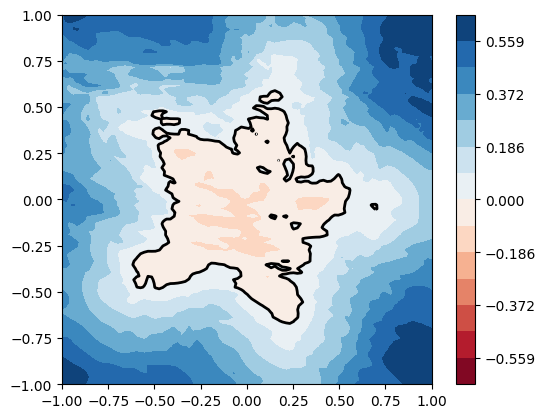

[100/200] Loss = 0.003044119104743004


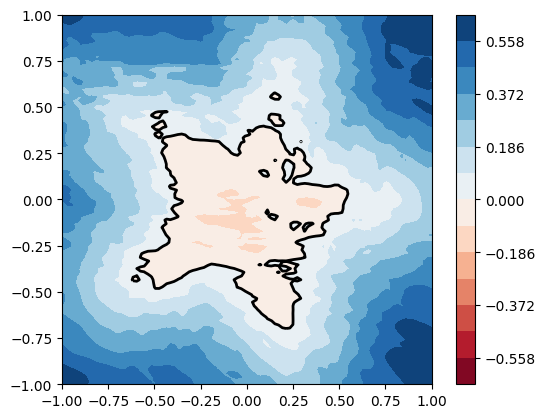

[105/200] Loss = 0.0032083773985505104


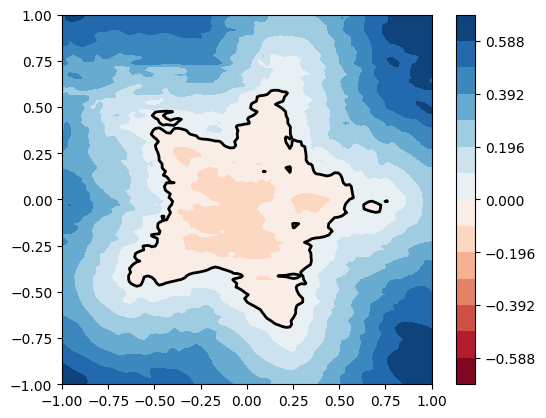

[110/200] Loss = 0.0020491587929427624


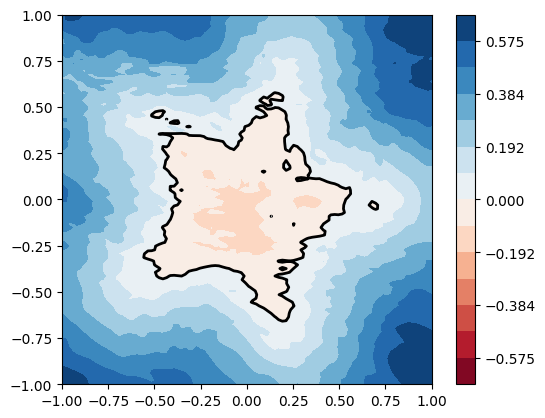

[115/200] Loss = 0.0025107250548899174


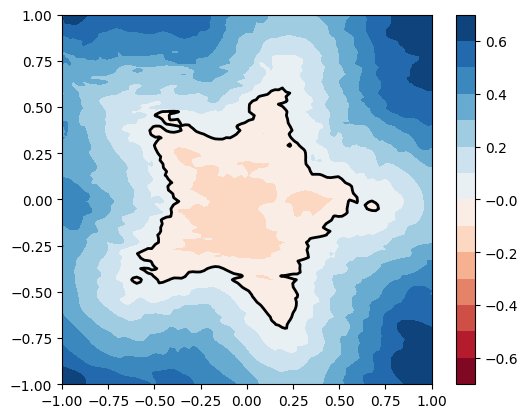

[120/200] Loss = 0.0016266353195533156


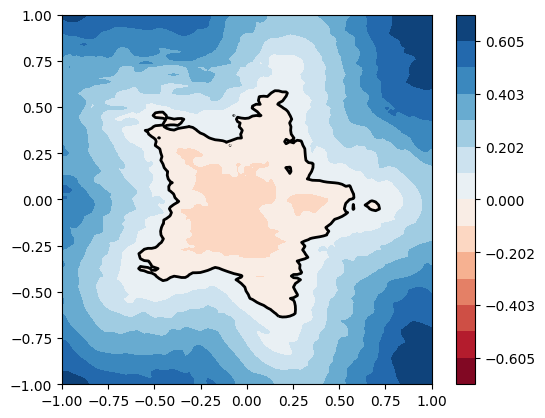

[125/200] Loss = 0.0013929427368566394


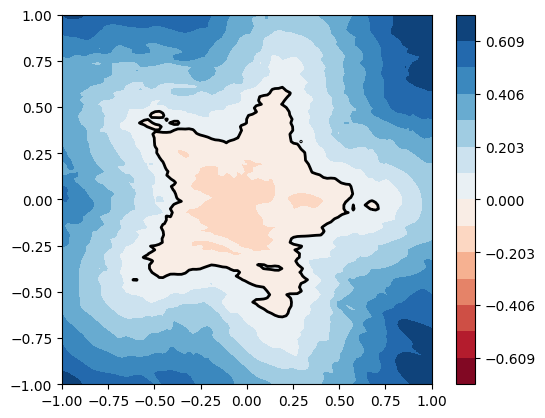

[130/200] Loss = 0.0014836215414106846


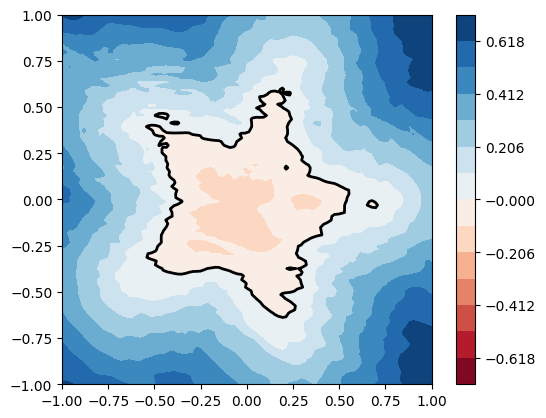

[135/200] Loss = 0.0014439549995586276


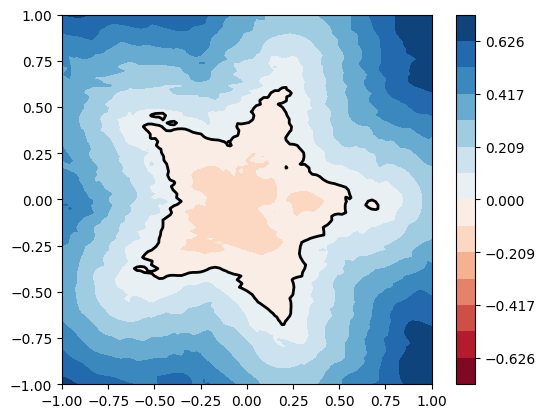

[140/200] Loss = 0.0010684824083000422


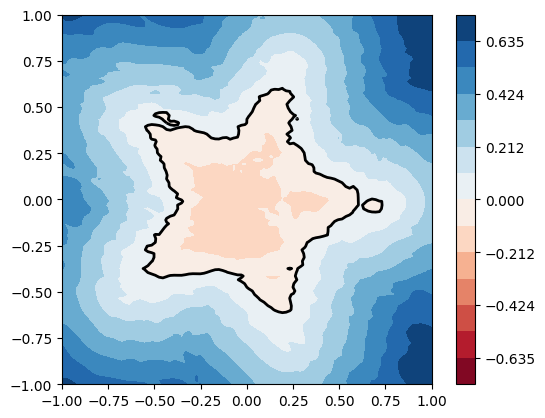

[145/200] Loss = 0.0008954944205470383


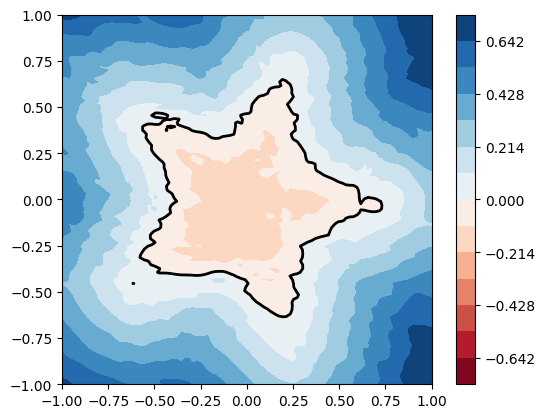

[150/200] Loss = 0.0008623945759609342


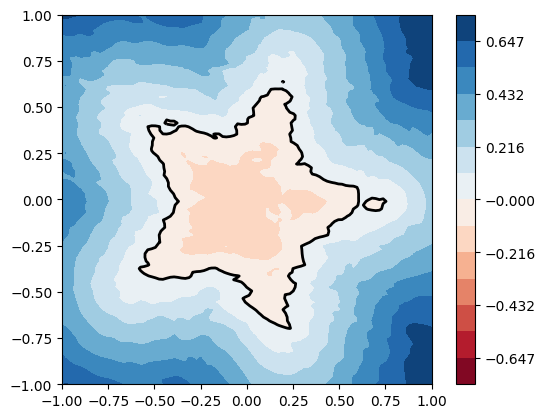

[155/200] Loss = 0.0007693606312386692


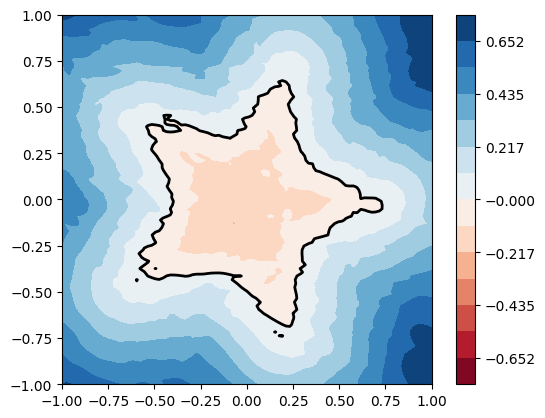

[160/200] Loss = 0.0007073133019730449


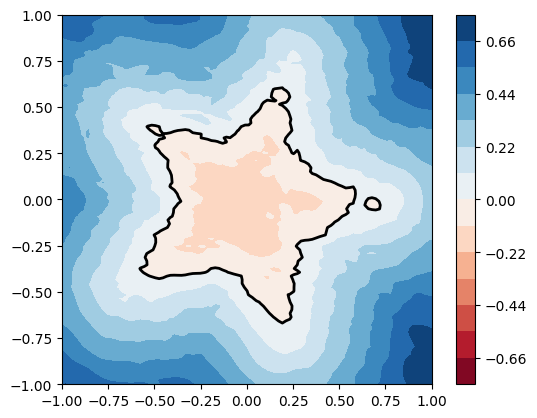

[165/200] Loss = 0.0007988839643076062


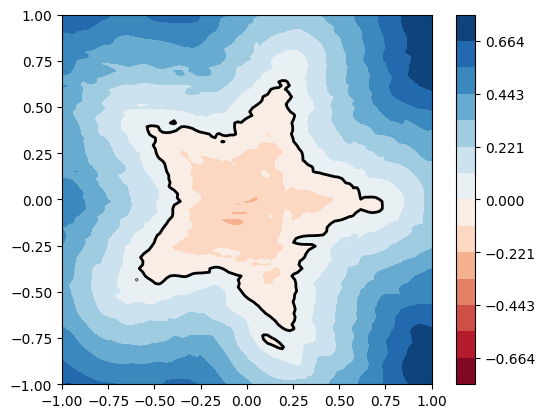

[170/200] Loss = 0.0007303126039914787


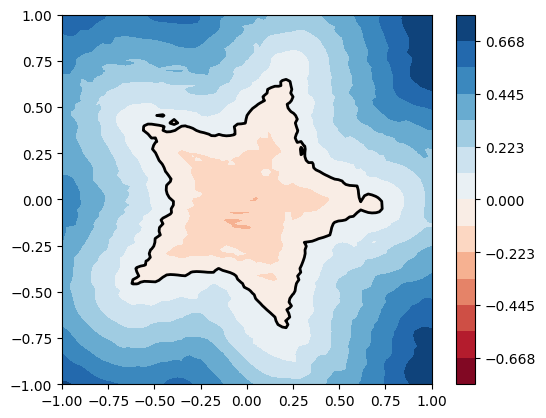

[175/200] Loss = 0.0006660017534159124


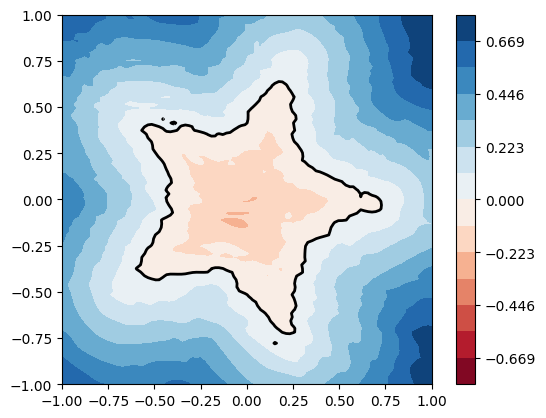

[180/200] Loss = 0.0006499917944893241


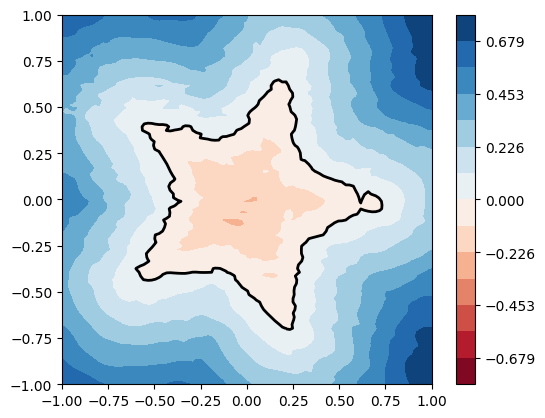

[185/200] Loss = 0.0004498197522480041


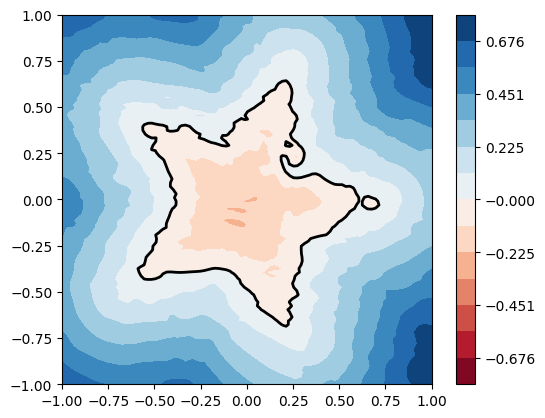

[190/200] Loss = 0.000519862282089889


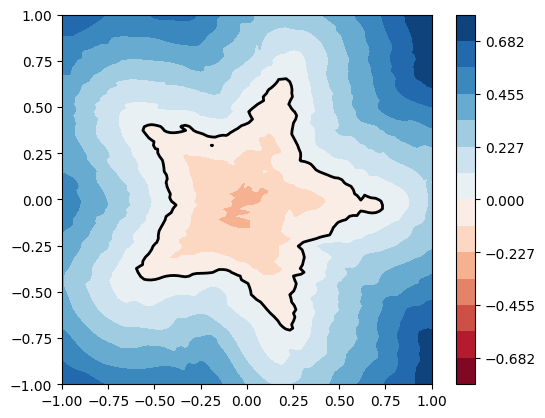

[195/200] Loss = 0.0006170194246806204


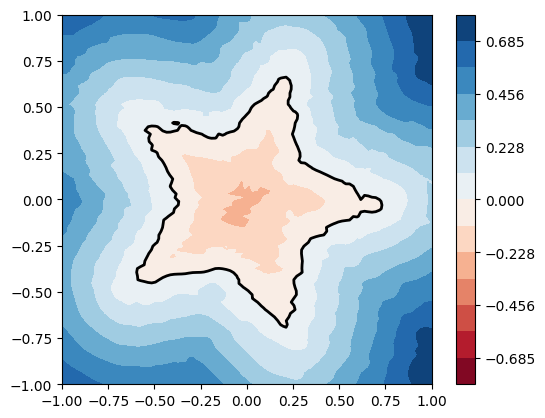

[200/200] Loss = 0.00034892381518147886
Executed in 2868.268364906311 seconds.


In [202]:
@timer
def train_sdf():
    for epoch in range(1, num_epochs+1):
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            preds = net(batch_x).flatten()
            mse_loss = nn.MSELoss()(preds, batch_y)
            eikonal_loss = get_eikonal_loss(batch_x, net)
            loss = mse_loss + 0.01 * eikonal_loss
            loss.backward()
            optimizer.step()
        
        # scheduler, evaluation
        net.eval()
        preds = net(X).flatten()
        loss = nn.MSELoss()(preds, Y)
        scheduler.step(loss)

        if epoch % print_every == 0:
            plot_sdf(net)
            print(f'[{epoch}/{num_epochs}] Loss = {loss}')

        net.train()

train_sdf()

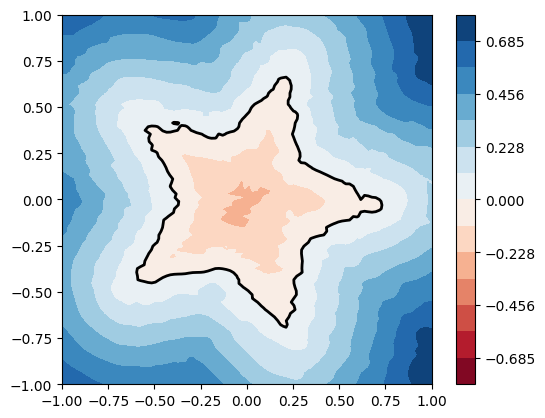

In [203]:
plot_sdf(net)

### 2. Solving the initial value problem

In [270]:
def get_pde_loss(net, V, input: dict, speed=1):
    phi_xt = net(input['xyt'])

    grad_phi = torch.autograd.grad(
        outputs=phi_xt,
        inputs= input['xyt'],
        grad_outputs=torch.ones_like(phi_xt),
        create_graph=True,
        only_inputs=True
    )[0]

    dx_phi = grad_phi[:, 0:-1]
    dt_phi = grad_phi[:, -1]

    Vx = V(input['xy'])
    n = input['xyt'].size(0) // input['xy'].size(0) # n = number of time steps

    prod = torch.einsum('ij, ij -> i', speed * Vx.repeat(n, 1), dx_phi).view(-1,1)

    return ((dt_phi + prod) ** 2).mean()

In [271]:
def get_ic_loss(pinn, f, input: dict):
    return ((pinn(input['xyt0']) - f(input['xy'])) ** 2).mean()

In [272]:
layer_sizes = [3, 1024, 1024, 1024, 1024, 512, 512, 256, 128, 1]
pinn = FullyConnected(layer_sizes).to(device)

In [273]:
learning_rate = 1e-3
optimizer = optim.Adam(pinn.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [274]:
n = 25
x0, x1, y0, y1 = -1, 1, -1, 1
t0, t1 = 0, 1

x = torch.linspace(x0, x1, n)
y = torch.linspace(y0, y1, n)
t = torch.linspace(t0, t1, n)

X, Y, T = torch.meshgrid(x, y, t, indexing='ij')
XT = torch.stack((X.flatten(), Y.flatten(), T.flatten()), dim=1).requires_grad_(True).to(device)

_X, _Y = torch.meshgrid(x, y, indexing='ij')
grid = torch.stack((_X.flatten(), _Y.flatten()), dim=1).to(device).requires_grad_(True)

T0 = torch.zeros_like(_X) 
XT0 = torch.stack((_X.flatten(), _Y.flatten(), T0.flatten()), dim=1).requires_grad_(True).to(device)

input_pde = dict(xyt=XT, xy=grid)
input_ic = dict(xyt0=XT0, xy=grid)

In [275]:
num_epochs = 5000
print_every = 5

In [276]:
@timer
def run_pinn_training(speed=10):
    for epoch in range(1, num_epochs+1):
        optimizer.zero_grad()
        #pde_loss = get_pde_loss(pinn, get_normal_field(net), input_pde, speed=speed)  
        #pde_loss = get_pde_loss(pinn, get_uniform_field(net), input_pde, speed=speed) 
        #pde_loss = get_pde_loss(pinn, get_mean_curvature_field(net), input_pde, speed=speed) 

        ic_loss = get_ic_loss(pinn, net, input_ic)
        loss = 0.01 * pde_loss + 1 * ic_loss
        loss.backward()
        optimizer.step()

        if epoch % print_every == 0:
            print(f'Epoch [{epoch}/{num_epochs}] Loss = {loss.item()}')
run_pinn_training()

Epoch [5/5000] Loss = 5348.10888671875


Epoch [10/5000] Loss = 338.60614013671875
Epoch [15/5000] Loss = 147.7559051513672
Epoch [20/5000] Loss = 109.1698989868164
Epoch [25/5000] Loss = 53.686038970947266
Epoch [30/5000] Loss = 38.89451217651367
Epoch [35/5000] Loss = 7.604963779449463
Epoch [40/5000] Loss = 2.1182613372802734
Epoch [45/5000] Loss = 0.6045495271682739
Epoch [50/5000] Loss = 0.8707702159881592
Epoch [55/5000] Loss = 0.7226723432540894
Epoch [60/5000] Loss = 0.5197166800498962
Epoch [65/5000] Loss = 0.3754061162471771
Epoch [70/5000] Loss = 0.29763174057006836
Epoch [75/5000] Loss = 0.2695128917694092
Epoch [80/5000] Loss = 0.2515696883201599
Epoch [85/5000] Loss = 0.2416989952325821
Epoch [90/5000] Loss = 0.2307778298854828
Epoch [95/5000] Loss = 0.22154250741004944
Epoch [100/5000] Loss = 0.21201303601264954
Epoch [105/5000] Loss = 0.20363901555538177
Epoch [110/5000] Loss = 0.19569551944732666
Epoch [115/5000] Loss = 0.18853062391281128
Epoch [120/5000] Loss = 0.1817476600408554
Epoch [125/5000] Loss = 0.1

In [277]:
generate_sdf_video(pinn)